In [1]:
import pandas as pd
from lib.util import info, idxwhere
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

import pyro
import pyro.distributions as dist
import torch
from functools import partial
import arviz as az
from pyro.ops.contract import einsum
import seaborn as sns
from tqdm import tqdm

In [2]:
def NegativeBinomialReparam(mu, r):
    p = 1 / ((r / mu) + 1)
    return dist.NegativeBinomial(
        total_count=r,
        probs=p
    )

def as_torch(x, dtype=torch.float32, device="cpu"):
    return torch.tensor(x, dtype=dtype, device=device)

def all_torch(dtype=torch.float32, device="cpu", **kwargs):
    # Cast inputs and set device
    return {k: as_torch(kwargs[k], dtype=dtype, device=device) for k in kwargs}

# Model2: Gumbel-Softmax with missing

In [164]:
def model2(
    n,
    g,
    s,
    gamma_hyper=as_torch(1.),
    delta_temp=as_torch(1.),
    delta_p=as_torch(0.9),
    rho_hyper=as_torch(1.),
    pi_hyper=as_torch(1.),
    mu_hyper_mean=as_torch(10.),
    mu_hyper_scale=as_torch(0.5),
    m_hyper=as_torch(1.),
    epsilon_hyper=as_torch(0.01),
    alpha_hyper=as_torch(100.),
):
    with pyro.plate('position', g, dim=-1):
        with pyro.plate('strain', s, dim=-2):
            # Allele
            gamma = pyro.sample(
                'gamma', dist.RelaxedBernoulli(temperature=gamma_hyper, probs=torch.tensor(0.5))
            )
            # Position presence/absence
            delta = pyro.sample(
                'delta', dist.RelaxedBernoulli(temperature=delta_temp, probs=delta_p)
            )
    
    # Meta-community strain composition
    rho = pyro.sample('rho', dist.RelaxedOneHotCategorical(temperature=rho_hyper, logits=torch.zeros(s)))
    
    alpha = pyro.sample('alpha', dist.Gamma(alpha_hyper, 1.)).unsqueeze(-1)
    
    with pyro.plate('sample', n, dim=-1):
        # Strain composition.
        pi = pyro.sample('pi', dist.RelaxedOneHotCategorical(temperature=pi_hyper, probs=rho))
        # Overdispersion of observations
        # Error rate
        epsilon = pyro.sample('epsilon', dist.Beta(1., 1 / epsilon_hyper)).unsqueeze(-1)
        # Fold coverage
        mu = pyro.sample('mu', dist.LogNormal(loc=torch.log(mu_hyper_mean), scale=mu_hyper_scale))

    
    # Expected fractions of each allele at each position
    nu = pyro.deterministic("nu", pi @ delta)
    p_noerr = pyro.deterministic('p_noerr', pi @ (gamma * delta) / nu)
    p = pyro.deterministic('p',
        (1 - epsilon / 2) * (p_noerr) +
        (epsilon / 2) * (1 - p_noerr)
    )
    
    # Depth at each position
    m = pyro.sample('m', NegativeBinomialReparam(nu * mu.reshape((-1,1)), m_hyper))
        
    y = pyro.sample(
        'y',
        dist.BetaBinomial(
            concentration1=alpha * p,
            concentration0=alpha * (1 - p),
            total_count=m
        ),
    )
    
#     y = pyro.sample(
#         'y',
#         dist.Binomial(
#             probs=p,
#             total_count=m
#         ),
#     )
    return y

In [165]:
n, g, s = 100, 200, 30

model2_sim = partial(
    pyro.condition(
        model2,
        data=all_torch(),
    ),
    s=s,
    g=g,
    n=n,
    **all_torch(
        gamma_hyper=0.01,
        pi_hyper=0.1,
        rho_hyper=2.,
        delta_temp=0.001,
        m_hyper=5,
        mu_hyper_mean=10,
        mu_hyper_scale=0.5,
    )
)

trace = pyro.poutine.trace(model2_sim).get_trace()
trace.compute_log_prob()
print(trace.format_shapes())

Trace Shapes:                  
 Param Sites:                  
Sample Sites:                  
position dist         |        
        value     200 |        
     log_prob         |        
  strain dist         |        
        value      30 |        
     log_prob         |        
   gamma dist  30 200 |        
        value  30 200 |        
     log_prob  30 200 |        
   delta dist  30 200 |        
        value  30 200 |        
     log_prob  30 200 |        
     rho dist         |  30    
        value         |  30    
     log_prob         |        
   alpha dist         |        
        value         |        
     log_prob         |        
  sample dist         |        
        value     100 |        
     log_prob         |        
      pi dist     100 |  30    
        value     100 |  30    
     log_prob     100 |        
 epsilon dist     100 |        
        value     100 |        
     log_prob     100 |        
      mu dist     100 |        
        

In [166]:
sim2 = pyro.infer.Predictive(model2_sim, num_samples=1)()
sim2 = {k: sim2[k].detach().cpu().numpy().squeeze() for k in sim2.keys()}

<AxesSubplot:>

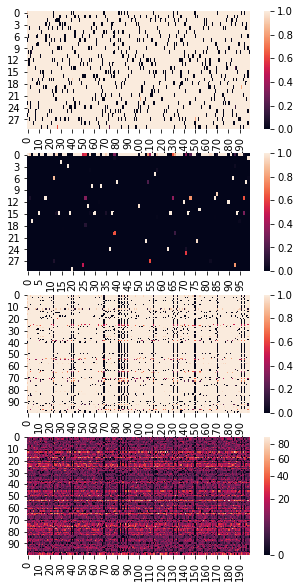

In [167]:
fig, axs = plt.subplots(4, figsize=(5, 10))

sns.heatmap(sim2['delta'], ax=axs[0], vmin=0, vmax=1)
sns.heatmap(sim2['pi'].T, ax=axs[1], vmin=0, vmax=1)
sns.heatmap(sim2['nu'], ax=axs[2], vmin=0, vmax=1)
sns.heatmap(sim2['m'], ax=axs[3], vmin=0, norm=mpl.colors.PowerNorm(1/2))

In [168]:
model2_fit = partial(
    pyro.condition(
        model2,
        data=all_torch(m=sim2['m'], y=sim2['y'])
    ),
    s=s,
    g=g,
    n=n,
    **all_torch(
        gamma_hyper=0.01,
        pi_hyper=0.1,
        rho_hyper=0.05,
        delta_temp=0.5,
        alpha_hyper=100.,
        m_hyper=5,
        mu_hyper_mean=10,
        mu_hyper_scale=2,
    )
)

_guide = pyro.infer.autoguide.AutoLaplaceApproximation(model2_fit)
opt = pyro.optim.Adamax({"lr": 1e-0}, {"clip_norm": 100.})
svi = pyro.infer.SVI(
    model2_fit,
    _guide,
    opt,
    loss=pyro.infer.Trace_ELBO()
)
pyro.clear_param_store()

n_iter = int(1e4)
lag = 100
history = []

In [171]:
pbar = tqdm(range(n_iter))
try:
    for i in pbar:
        elbo = svi.step()
        if np.isnan(elbo):
            print("ELBO = NaN")
            break
        history.append(elbo)

        # Reporting/Breaking
        if (i % 1 == 0):
            if i > lag:
                delta_lag = (history[-lag] - history[-1]) / lag
                pbar.set_postfix({
                    'ELBO': history[-1],
                    'delta': history[-2] - history[-1],
                    f'lag{lag}': delta_lag,
                })
                if delta_lag < 0:
                    print(f"Converged: {elbo}")
                    elbo = svi.step()
                    break
except KeyboardInterrupt:
    print("Interrupted")
finally:
    pbar.refresh()
    est2 = pyro.infer.Predictive(model2_fit, guide=_guide, num_samples=1)()
    est2 = {k: est2[k].detach().cpu().numpy().mean(axis=0).squeeze() for k in est2.keys()}

  1%|          | 119/10000 [00:02<03:20, 49.30it/s, ELBO=1.23e+5, delta=-2.31, lag100=-.00052]


Converged: 122599.49563550949


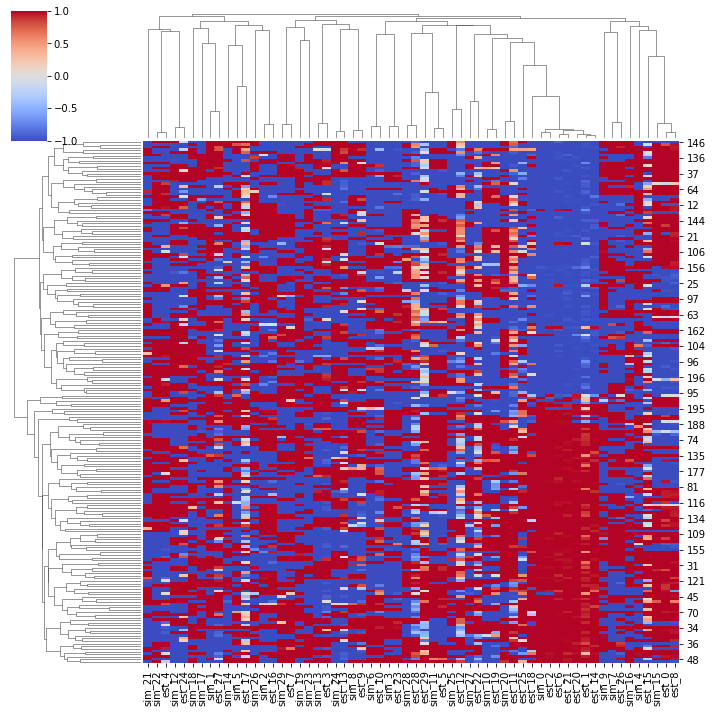

In [172]:
combined_gamma = pd.concat([
    pd.DataFrame(sim2['gamma'], index=[f'sim_{i}' for i in range(len(sim2['gamma']))]),
    pd.DataFrame(est2['gamma'], index=[f'est_{i}' for i in range(len(est2['gamma']))]),
])

sns.clustermap(combined_gamma.T * 2 - 1, vmin=-1, vmax=1, cmap='coolwarm', metric='cosine', xticklabels=1)
#sns.heatmap(est2['gamma'] * 2 - 1, ax=axs[1], vmin=-1, vmax=1, cmap='coolwarm')

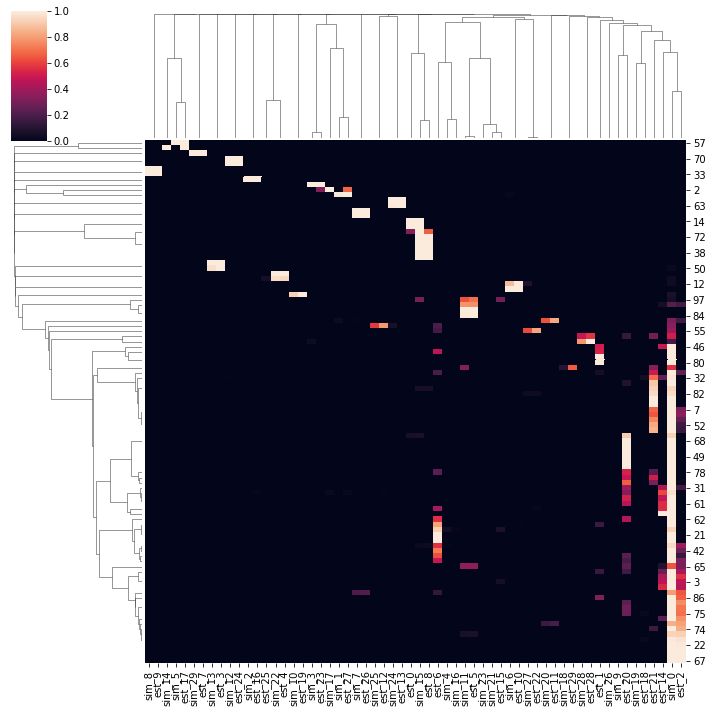

In [173]:
combined_pi = pd.concat([
    pd.DataFrame(sim2['pi'].T, index=[f'sim_{i}' for i in range(len(sim2['pi'].T))]),
    pd.DataFrame(est2['pi'].T, index=[f'est_{i}' for i in range(len(est2['pi'].T))]),
])

sns.clustermap(combined_pi.T, vmin=0, vmax=1, metric='cosine', xticklabels=1)
#sns.heatmap(est2['gamma'] * 2 - 1, ax=axs[1], vmin=-1, vmax=1, cmap='coolwarm')

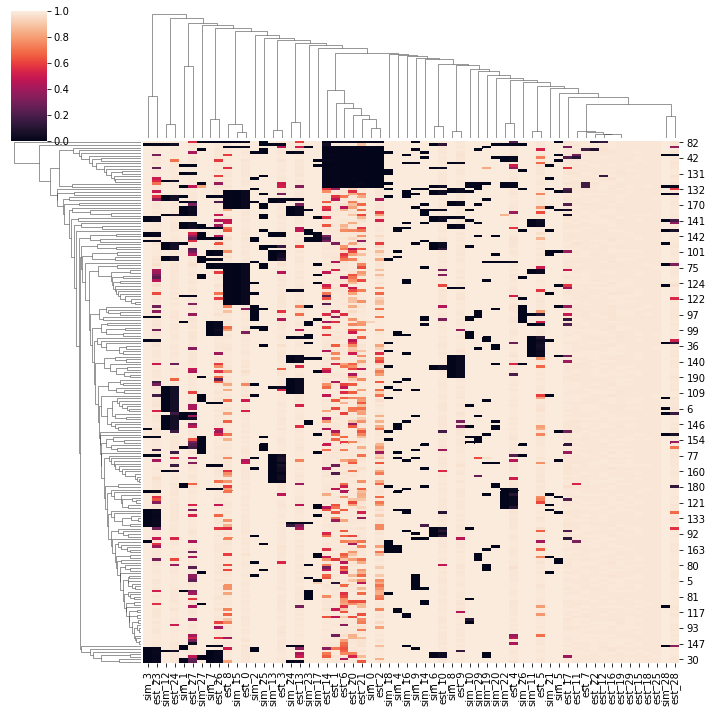

In [174]:
combined_delta = pd.concat([
    pd.DataFrame(sim2['delta'], index=[f'sim_{i}' for i in range(len(sim2['delta']))]),
    pd.DataFrame(est2['delta'], index=[f'est_{i}' for i in range(len(est2['delta']))]),
])

sns.clustermap(combined_delta.T, vmin=0, vmax=1, metric='cosine', xticklabels=1)
#sns.heatmap(est2['gamma'] * 2 - 1, ax=axs[1], vmin=-1, vmax=1, cmap='coolwarm')

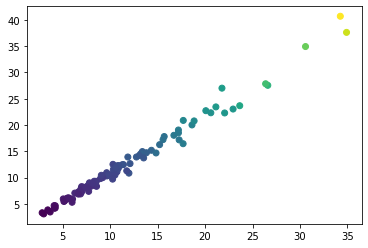

In [175]:
plt.scatter(sim2['mu'], est2['mu'], c=sim2['m'].mean(1))

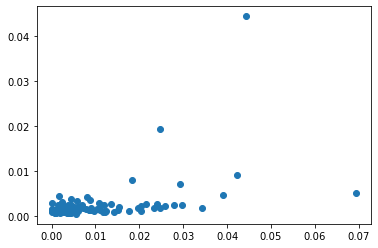

In [176]:
plt.scatter(sim2['epsilon'], est2['epsilon'])

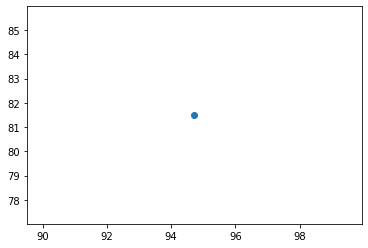

In [177]:
plt.scatter(sim2['alpha'], est2['alpha'])

# Model0: Dirichlet

In [ ]:
def model0(
    n,
    g,
    s,
    gamma_hyper=as_torch(1.),
    rho_hyper=as_torch(1.),
    pi_hyper=as_torch(1.),
    m_hyper_mu=as_torch(10.),
    m_hyper_r=as_torch(1.),
    epsilon_hyper=as_torch(0.01),
    alpha_hyper=as_torch(100.),
):
    
    with pyro.plate('position', g, dim=-1):
        with pyro.plate('strain', s, dim=-2):
            gamma = pyro.sample(
                'gamma', dist.Beta(gamma_hyper, gamma_hyper)
            )
    
#     rho_ = pyro.sample('rho_', dist.LogNormal(0, 1 / rho_hyper).expand([s]).to_event())
#     rho = pyro.deterministic('rho', rho_ / rho_.sum())
    rho = pyro.sample('rho', dist.Dirichlet(torch.ones(s) * rho_hyper))
    
    with pyro.plate('sample', n, dim=-1):
        pi = pyro.sample('pi', dist.Dirichlet(rho * pi_hyper * s))
        alpha = pyro.sample('alpha', dist.Gamma(alpha_hyper, 1.)).unsqueeze(-1)
        epsilon = pyro.sample('epsilon', dist.Beta(1., 1 / epsilon_hyper)).unsqueeze(-1)
        
    m = pyro.sample('m', NegativeBinomialReparam(m_hyper_mu, m_hyper_r).expand([n, g]))

    p_noerr = pyro.deterministic('p_noerr', pi @ gamma)
    p = pyro.deterministic('p',
        (1 - epsilon / 2) * (p_noerr) +
        (epsilon / 2) * (1 - p_noerr)
    )
        
    y = pyro.sample(
        'y',
        dist.BetaBinomial(
            concentration1=alpha * p,
            concentration0=alpha * (1 - p),
            total_count=m
        ),
    )
    return y

In [ ]:
n, g, s = 500, 1000, 100

model0_sim = partial(
    pyro.condition(
        model0,
        data={
        },
    ),
    s=s,
    g=g,
    n=n,
    **as_torch(
        gamma_hyper=0.1,
        pi_hyper=0.001,
        rho_hyper=1.,
    )
)

trace = pyro.poutine.trace(model0_sim).get_trace()
trace.compute_log_prob()
print(trace.format_shapes())

In [ ]:
sim = pyro.infer.Predictive(model0_sim, num_samples=1)()
sim = {k: sim[k].detach().cpu().numpy().squeeze() for k in sim.keys()}

sns.heatmap(sim['pi'])

In [ ]:
plt.plot(np.sort(sim['rho']))

In [ ]:
# gamma_hyper_fit = torch.autograd.Variable(torch.tensor(1.))
# pi_hyper_fit = torch.autograd.Variable(torch.tensor(1.))
# rho_hyper_fit = torch.autograd.Variable(torch.tensor(1.))


model0_fit = partial(
    pyro.condition(
        model0,
        data={
            'm': torch.tensor(sim['m']),
            'y': torch.tensor(sim['y']),
        },
    ),
    s=s,
    g=g,
    n=n,
    **as_torch(
        pi_hyper=1.0,
        rho_hyper=1.0,
        gamma_hyper=1.0,
    )
)

_guide = pyro.infer.autoguide.AutoLaplaceApproximation(model0_fit)
opt = pyro.optim.Adamax({"lr": 1e-0}, {"clip_norm": 100.})
svi = pyro.infer.SVI(
    model0_fit,
    _guide,
    opt,
    loss=pyro.infer.JitTrace_ELBO()
)
pyro.clear_param_store()

n_iter = int(5e2)
# step_hypers_at = int(5e2)
# start_pi_shift_at = int(5e3)
# pi_hyper_schedule = np.concatenate([
#     np.logspace(0.01, 0, start_pi_shift_at // step_hypers_at),
#     np.logspace(0, -1.0, (n_iter - start_pi_shift_at) // step_hypers_at),
# ]).astype('float32')
# rho_hyper_schedule = np.logspace(0, -2, num=n_iter // step_hypers_at).astype('float32')
# gamma_hyper_schedule = np.logspace(0, -2, num=n_iter // step_hypers_at).astype('float32')
# plt.scatter(rho_hyper_schedule, pi_hyper_schedule, c=np.linspace(0, 1, num=pi_hyper_schedule.shape[0]))
# plt.yscale('log')
# plt.xscale('log')

history = []

In [ ]:
pbar = tqdm(range(n_iter))
for i in pbar:
#     pi_hyper_fit.data = torch.tensor(pi_hyper_schedule[i // step_hypers_at])
#     rho_hyper_fit.data = torch.tensor(rho_hyper_schedule[i // step_hypers_at])
#     gamma_hyper_fit.data = torch.tensor(gamma_hyper_schedule[i // step_hypers_at])
#     pi_hyper_fit.data = torch.tensor(1.)
#     rho_hyper_fit.data = torch.tensor(1.)
#     gamma_hyper_fit.data = torch.tensor(1.)

    elbo = svi.step()
    
    if np.isnan(elbo):
        break

    # Fit tracking
    history.append(elbo)
    
    # Reporting/Breaking
    if (i % 1 == 0):
        if i > 1:
            pbar.set_postfix({
                'ELBO': history[-1],
                'delta': history[-2] - history[-1],
#                 'pi_hyper': pi_hyper_fit,
#                 'rho_hyper': rho_hyper_fit,
#                 'gamma_hyper': gamma_hyper_fit,
            })

In [ ]:
plt.plot(history)

In [ ]:
est = pyro.infer.Predictive(model0_fit, guide=_guide, num_samples=1)()
est = {k: est[k].detach().cpu().numpy().squeeze() for k in sim.keys()}

In [ ]:
sns.heatmap(est['pi'])

In [ ]:
sns.heatmap(est['gamma'].T)

In [ ]:
plt.plot(np.sort(est['rho']))

# Model1: Gumbel-Softmax

In [ ]:
def model1(
    n,
    g,
    s,
    gamma_hyper=torch.tensor(1.),
    rho_hyper=torch.tensor(1.),
    pi_hyper=torch.tensor(1.),
    m_hyper_mu=torch.tensor(10.),
    m_hyper_r=torch.tensor(1.),
    epsilon_hyper=torch.tensor(0.01),
    alpha_hyper=torch.tensor(100.),
):
    
    with pyro.plate('position', g, dim=-1):
        with pyro.plate('strain', s, dim=-2):
            gamma = pyro.sample(
                'gamma', dist.RelaxedBernoulli(temperature=gamma_hyper, probs=torch.tensor(0.5))
            )
    
#     rho_ = pyro.sample('rho_', dist.LogNormal(0, 1 / rho_hyper).expand([s]).to_event())
#     rho = pyro.deterministic('rho', rho_ / rho_.sum())
    rho = pyro.sample('rho', dist.RelaxedOneHotCategorical(temperature=rho_hyper, logits=torch.zeros(s)))
    
    with pyro.plate('sample', n, dim=-1):
        pi = pyro.sample('pi', dist.RelaxedOneHotCategorical(temperature=pi_hyper, probs=rho))
        alpha = pyro.sample('alpha', dist.Gamma(alpha_hyper, 1.)).unsqueeze(-1)
        epsilon = pyro.sample('epsilon', dist.Beta(1., 1 / epsilon_hyper)).unsqueeze(-1)
        
    m = pyro.sample('m', NegativeBinomialReparam(m_hyper_mu, m_hyper_r).expand([n, g]))

    p_noerr = pyro.deterministic('p_noerr', pi @ gamma)
    p = pyro.deterministic('p',
        (1 - epsilon / 2) * (p_noerr) +
        (epsilon / 2) * (1 - p_noerr)
    )
        
    y = pyro.sample(
        'y',
        dist.BetaBinomial(
            concentration1=alpha * p,
            concentration0=alpha * (1 - p),
            total_count=m
        ),
    )
    return y

In [ ]:
n, g, s = 500, 1000, 100

model1_sim = partial(
    pyro.condition(
        model1,
        data={
        },
    ),
    s=s,
    g=g,
    n=n,
    **as_torch(
        gamma_hyper=0.1,
        pi_hyper=0.1,
        rho_hyper=1.,
    )
)

trace = pyro.poutine.trace(model1_sim).get_trace()
trace.compute_log_prob()
print(trace.format_shapes())

In [ ]:
# gamma_hyper_fit = torch.autograd.Variable(torch.tensor(1.))
# pi_hyper_fit = torch.autograd.Variable(torch.tensor(1.))
# rho_hyper_fit = torch.autograd.Variable(torch.tensor(1.))


model1_fit = partial(
    pyro.condition(
        model1,
        data={
            'm': torch.tensor(sim['m']),
            'y': torch.tensor(sim['y']),
        },
    ),
    s=s,
    g=g,
    n=n,
    **as_torch(
        gamma_hyper=1.,
        pi_hyper=1.,
        rho_hyper=1.,
    )
)

_guide = pyro.infer.autoguide.AutoLaplaceApproximation(model1_fit)
opt = pyro.optim.Adamax({"lr": 1e-0}, {"clip_norm": 100.})
svi = pyro.infer.SVI(
    model1_fit,
    _guide,
    opt,
    loss=pyro.infer.JitTrace_ELBO()
)
pyro.clear_param_store()

n_iter = int(5e2)
# step_hypers_at = int(5e2)
# start_pi_shift_at = int(5e3)
# pi_hyper_schedule = np.concatenate([
#     np.logspace(0.01, 0, start_pi_shift_at // step_hypers_at),
#     np.logspace(0, -1.0, (n_iter - start_pi_shift_at) // step_hypers_at),
# ]).astype('float32')
# rho_hyper_schedule = np.logspace(0, -2, num=n_iter // step_hypers_at).astype('float32')
# gamma_hyper_schedule = np.logspace(0, -2, num=n_iter // step_hypers_at).astype('float32')
# plt.scatter(rho_hyper_schedule, pi_hyper_schedule, c=np.linspace(0, 1, num=pi_hyper_schedule.shape[0]))
# plt.yscale('log')
# plt.xscale('log')

history = []

In [ ]:
pbar = tqdm(range(n_iter))
for i in pbar:
#     pi_hyper_fit.data = torch.tensor(pi_hyper_schedule[i // step_hypers_at])
#     rho_hyper_fit.data = torch.tensor(rho_hyper_schedule[i // step_hypers_at])
#     gamma_hyper_fit.data = torch.tensor(gamma_hyper_schedule[i // step_hypers_at])
#     pi_hyper_fit.data = torch.tensor(1.)
#     rho_hyper_fit.data = torch.tensor(1.)
#     gamma_hyper_fit.data = torch.tensor(1.)

    elbo = svi.step()
    
    if np.isnan(elbo):
        break

    # Fit tracking
    history.append(elbo)
    
    # Reporting/Breaking
    if (i % 1 == 0):
        if i > 1:
            pbar.set_postfix({
                'ELBO': history[-1],
                'delta': history[-2] - history[-1],
#                 'pi_hyper': pi_hyper_fit,
#                 'rho_hyper': rho_hyper_fit,
#                 'gamma_hyper': gamma_hyper_fit,
            })

In [ ]:
plt.plot(history)

In [ ]:
est = pyro.infer.Predictive(model1_fit, guide=_guide, num_samples=1)()
est = {k: est[k].detach().cpu().numpy().squeeze() for k in sim.keys()}

In [ ]:
plt.plot(np.sort(est['rho']))

In [ ]:
sns.heatmap(est['pi'])

In [ ]:
sns.heatmap(est['gamma'].T)

In [ ]:
plt.plot(np.sort(est['rho']))